# MNIST MLP Classifier


## Multiclass Classifier

This Jupyter notebook builds a simple Multilayer Perceptron (MLP) classifier using Keras for the MNIST dataset. 

## Dataset

https://www.kaggle.com/oddrationale/mnist-in-csv


## Objective

Use the MNIST dataset to build a MLP for classification.

Import standard data processing and visualization libraries.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

TRAIN_DATA_PATH = "/Users/jeffguo/PycharmProjects/MNIST MLP/mnist_train.csv"
TEST_DATA_PATH = "/Users/jeffguo/PycharmProjects/MNIST MLP/mnist_test.csv"

raw_train_data = pd.read_csv(TRAIN_DATA_PATH)
raw_test_data = pd.read_csv(TEST_DATA_PATH)

Gain a basic understanding of the data.

In [2]:
print(f"Train Set Shape: {raw_train_data.shape}, Missing Data: {raw_train_data.isnull().values.any()}")
print(f"Test Set Shape: {raw_test_data.shape}, Missing Data: {raw_test_data.isnull().values.any()}\n")

print(raw_train_data.info())

raw_train_data.head(3)

Train Set Shape: (60000, 785), Missing Data: False
Test Set Shape: (10000, 785), Missing Data: False

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB
None


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The train and test sets contain 60,000 and 10,000 entries, respectively. Importantly, there are no missing data points. A quick glance at the first 5 entries of the train set show that 1/785 columns pertains to the label and the other 784/785 pertains to the pixels of the MNIST digit. Finally, the only datatype in the dataset is "int64". 

Let's next visualize some of the MNIST digits.

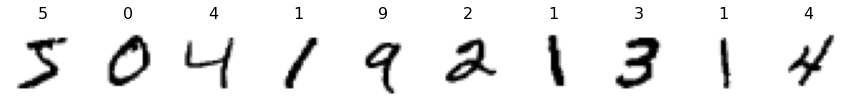

In [3]:
# create a temporary DataFrame for visualization purposes
plot_ten_df = raw_train_data.drop("label", axis=1).iloc[0:10, :]
plt.rcParams['figure.figsize'] = [15, 15]

# visualize the first 10 digits in the train set 
for index in range(10):
    plt.subplot(1, 10, index+1)
    # reshape pixel arragement to 28 x 28
    digit_array = np.asarray(plot_ten_df.iloc[index]).reshape(28, 28)
    plt.imshow(digit_array, cmap="binary")
    plt.title(raw_train_data["label"].iloc[index], fontsize=16)
    plt.axis("off")

As expected, each entry in the dataset maps to a 28 x 28 pixel handwritten digit. The corresponding labels are already encoded and represent the digit number.


At the moment, each pixel is represented by an "int64" with values [0-255]. We will use Gradient Descent for MLP training which is sensitive to feature scales. Therefore, let's normalize the pixel values to speed up Gradient Descent convergence.

In [4]:
# separate the pixels and the label
# cast int pixels to float
X_train = np.array(raw_train_data.drop("label", axis=1)).astype(float)
y_train = np.array(raw_train_data["label"])

X_test = np.array(raw_test_data.drop("label", axis=1)).astype(float)
y_test = np.array(raw_test_data["label"])

# divide by 255 to normalize 
# reshape arrays to 28 x 28 to match the pixel format
X_train = (X_train / 255).reshape(60000, 28, 28)
X_test = (X_test / 255).reshape(10000, 28, 28) 

Next, let's separate the pixels and the label from the train and test set. The train set will also be split to generate a validation set.

In [5]:
from sklearn.model_selection import train_test_split

# random_state=42 for reproducibility
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# verify the set sizes are as expected
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_val Shape: {X_val.shape}, y_val Shape: {y_val.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

X_train Shape: (51000, 28, 28), y_train Shape: (51000,)
X_val Shape: (9000, 28, 28), y_val Shape: (9000,)
X_test Shape: (10000, 28, 28), y_test Shape: (10000,)


We are now ready to construct the neural network! The Keras API will be be used to build the MLP.

In [6]:
import tensorflow as tf

# random_seed=42 for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# build the MLP architecture
mlp_model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape=[28, 28], name="input_layer"),
                tf.keras.layers.Dense(150, activation="relu", name="hidden_layer1"),
                tf.keras.layers.Dense(100, activation="relu", name="hidden_layer2"),
                tf.keras.layers.Dense(50, activation="relu", name="hidden_layer3"),
                tf.keras.layers.Dense(10, activation="softmax", name="output_layer")
])

# compile MLP model
mlp_model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="sgd",
                  metrics=["accuracy"])

# display a breakdown of the MLP model
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Flatten)        (None, 784)               0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 150)               117750    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 100)               15100     
_________________________________________________________________
hidden_layer3 (Dense)        (None, 50)                5050      
_________________________________________________________________
output_layer (Dense)         (None, 10)                510       
Total params: 138,410
Trainable params: 138,410
Non-trainable params: 0
_________________________________________________________________


Key features of the MLP:

1) Input layer 28 x 28 to match the MNIST pixel format

2) Output layer has 10 neurons as there are 10 possible MNIST digits --> [0-9]

The MLP is now ready for training! Let's define an early stopping callback that monitors the validation set cross entropy loss function. If the cost doesn't decrease after 10 epochs, stop model training as further improvements are unlikely. By using this callback, we can set the number of epochs during model training to a large number, mitigating concerns over underfitting/overfitting as there is now a built-in stopping mechanism. 

In [7]:
# define an early stopping callback, monitoring the validation cross-entropy loss function
val_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# train the MLP
training_progress = mlp_model.fit(X_train, y_train, epochs=1000,
                                  validation_data=(X_val, y_val),
                                  callbacks=[val_stop])

Train on 51000 samples, validate on 9000 samples
Epoch 1/1000
51000/51000 [==============================] - 7s 132us/sample - loss: 0.7644 - accuracy: 0.7904 - val_loss: 0.3222 - val_accuracy: 0.9060
Epoch 2/1000
51000/51000 [==============================] - 6s 110us/sample - loss: 0.2858 - accuracy: 0.9164 - val_loss: 0.2538 - val_accuracy: 0.9257
Epoch 3/1000
51000/51000 [==============================] - 6s 112us/sample - loss: 0.2261 - accuracy: 0.9345 - val_loss: 0.2080 - val_accuracy: 0.9372
Epoch 4/1000
51000/51000 [==============================] - 6s 110us/sample - loss: 0.1884 - accuracy: 0.9445 - val_loss: 0.1811 - val_accuracy: 0.9458
Epoch 5/1000
51000/51000 [==============================] - 6s 110us/sample - loss: 0.1617 - accuracy: 0.9527 - val_loss: 0.1589 - val_accuracy: 0.9526
Epoch 6/1000
51000/51000 [==============================] - 6s 113us/sample - loss: 0.1425 - accuracy: 0.9585 - val_loss: 0.1439 - val_accuracy: 0.9550
Epoch 7/1000
51000/51000 [=============

Next, let's plot the model training progression.

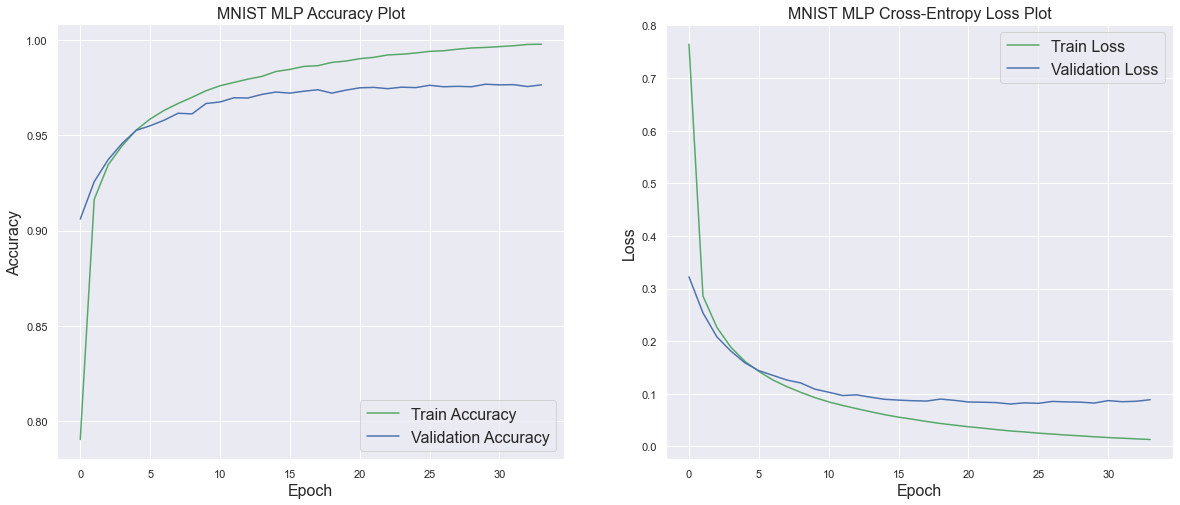

In [10]:
# define a function to plot the MLP training history
def training_plots(training_progress: dict):
    
    sb.set_theme()
    plt.rcParams['figure.figsize'] = [20, 8]
    
    plt.subplot(1, 2, 1)
    plt.plot(training_progress["accuracy"], "g", label="Train Accuracy")
    plt.plot(training_progress["val_accuracy"], "b", label="Validation Accuracy")
    plt.title("MNIST MLP Accuracy Plot", fontsize=16)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.legend(fontsize=16)
    
    plt.subplot(1, 2, 2)
    plt.plot(training_progress["loss"], "g", label="Train Loss")
    plt.plot(training_progress["val_loss"], "b", label="Validation Loss")
    plt.title("MNIST MLP Cross-Entropy Loss Plot", fontsize=16)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(fontsize=16)
    
training_plots(training_progress.history)

Key Observations:

1) Accuracy on the train set almost reaches 1

2) Accuracy on the validation set is lower than the train set, as expected, but is not significantly worse

3) The callback mechanism worked as intended as val_loss plateaus at ~20 epochs

Let's now evaluate the MLP on the test set.

In [11]:
test_accuracy = mlp_model.evaluate(X_test, y_test, verbose=0)[1]

final_results = pd.DataFrame({"Model": ["Multilayer Perception (MLP)"],
                              "Train Accuracy": [0.9978],
                              "Validation Accuracy": [0.9764],
                              "Test Accuracy": [test_accuracy]})

print(final_results.to_string(index=False))

                      Model  Train Accuracy  Validation Accuracy  Test Accuracy
Multilayer Perception (MLP)          0.9978               0.9764         0.9774


The test accuracy is quite close to the validation accuracy, as expected, since no hyperparameter tuning was performed. If we did perform hyperparameter tuning, the MLP would use the hyperparameters that perform the best on the validation set which would likely result in a decreased performance on the test set. 

To conclude, the simple MLP achieved ~97.7% accuracy on the MNIST dataset.